## Laplacian Eigenvalues of Network Data

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pickle, json, os, sys, csv, random, operator
from collections import defaultdict, Counter, deque
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.linalg as la
from itertools import combinations, product
sys.path.insert(0, '../yitong_ngm_repo/')
import utils
from matplotlib.ticker import MultipleLocator

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

import triangulate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
ratio = lambda l: max(l)/min(l)

def add_random_edges(graph, percents):
    graphs = []
    for percent in percents:
        g = graph.copy()
        nids = g.vs.indices
        num_edges = int(round(percent*len(g.es)))
        edges = []
        for idx in xrange(num_edges):
            node1, node2 = np.random.choice(nids, size=2, replace=False)
            edges.append((node1, node2))
        g.add_edges(edges)
        graphs.append(g)
    return graphs

def trim_high_degree_nodes(graph, max_degs):
    graphs = []
    for max_deg in max_degs:
        g = graph.copy()
        del_edges = []
        for node in g.vs:
            if node.degree() > max_deg:
                nbors = node.neighbors(mode='ALL')
                del_nbors = np.random.choice(nbors, size=node.degree()-max_deg, replace=False)
                for nb in del_nbors: del_edges.append((node.index, nb.index))

        g.delete_edges(del_edges)
        graphs.append(g)
    return graphs
    

def get_laplacian_minmax(g):
    g = g.as_undirected()
    L = np.array(g.laplacian())
    eigvals = la.eigvalsh(L)
    eigvals = np.round(eigvals, 4)
    eigvals = eigvals[eigvals > 0]
    return min(eigvals), max(eigvals), ratio(eigvals)

In [3]:
# load data
path = 'data/'
paths = [os.path.join(path, f) for f in os.listdir(path) if not f.startswith('.')]

networks = {}
for gpath in paths:
    fname = gpath.rsplit('/', 1)[-1].split('.')[0]
    if fname not in ['acl', 'hepph']: continue
    g = networks[fname] = ig.Graph.Read_Pickle(gpath)
    networks[fname].vs['nid'] = g.vs.indices

    print fname
    print networks[fname].summary() 

hepph
IGRAPH DN-- 30558 347228 -- 
+ attr: attributed (g), attributes (g), single_attr (g), month (v), name (v), nid (v), time (v), year (v)
acl
IGRAPH DN-- 18665 115311 -- 
+ attr: attributed (g), attributes (g), single_attr (g), attrs (v), id (v), name (v), nid (v), single_attr (v), time (v), venue_id (v)


### Dataset

In [18]:
# acl
def acl_graph():    
    g = networks['acl']
    yk, ck = map(np.array, zip(*sorted(Counter(g.vs['time']).items())))
    max_year = max(yk[ck.cumsum() < 3000])
    sg = g.subgraph([n for n in g.vs if n['time'] <= max_year])

    sg = sg.as_undirected()
    print min(set(sg.vs['time'])), max(set(sg.vs['time']))
    sg.summary()
    return sg

# HepPH
def hepph_graph():
    g = networks['hepph']
    yk, ck = map(np.array, zip(*sorted(Counter(g.vs['year']).items())))
    max_year = max(yk[ck.cumsum() < 10000])
    sg = g.subgraph([n for n in g.vs if n['year'] <= max_year])

    sg = sg.as_undirected()
    print min(set(sg.vs['year'])), max(set(sg.vs['year']))
    sg.summary()
    return sg

In [19]:
sg = ig.Graph.Erdos_Renyi(500, m=2500)
sg_ch = triangulate.triangulate_ig(sg)

490 480 470 460 450 440 430 420 410 400 390 380 370 360 350 340 330 320 310 300 290 280 270 260 250 240 230 220 210 200 190 180 170 160 150 140 130 120 110 100 90 80 70 60 50 40 30 20 10 0


In [13]:
sg_ch.simplify().summary()

'IGRAPH U--- 500 69166 -- '

### Adding edges u.a.r.

In [218]:
percents = np.arange(0.1, 0.91, 0.15)
graphs = add_random_edges(sg, percents)

In [219]:
eigdata = []
for g in graphs:
    d = get_laplacian_minmax(g)
    eigdata.append(d)
    print d

(0.0766, 154.152, 2012.4281984334202)
(0.2832, 152.167, 537.3128531073446)
(0.5622, 153.1809, 272.4669156883671)
(0.6795, 152.1969, 223.98366445916116)
(0.6671, 156.1943, 234.13925948133712)
(0.8769, 155.2115, 177.00022807617745)


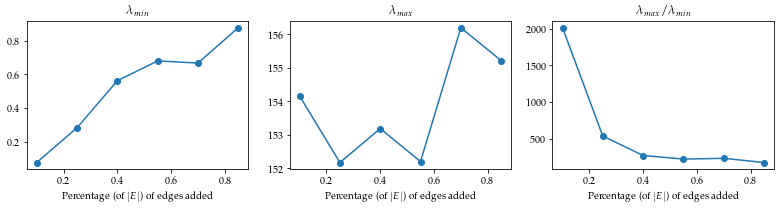

In [220]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,3))

eigmin, eigmax, eigratio = zip(*eigdata)
labels =[r'$\lambda_{min}$', r'$\lambda_{max}$', r'$\lambda_{max}/\lambda_{min}$']
for ax, data, label in zip(fig.axes, [eigmin, eigmax, eigratio], labels):
    ax.plot(percents, data, '-o')
    ax.set_title(label)
    ax.set_xlabel('Percentage (of $|E|$) of edges added')
fig.tight_layout()

## Trimming high degree nodes

In [221]:
pctiles = [int(np.percentile(sg.degree(), p)) for p in [99.999, 99.99, 99.9, 99, 98]]
graphs = trim_high_degree_nodes(sg, pctiles)

In [222]:
eigdata2 = []
for g in graphs:
    d = get_laplacian_minmax(g)
    eigdata2.append(d)
    print d

(0.0516, 148.1622, 2871.360465116279)
(0.0516, 139.2023, 2697.718992248062)
(0.0516, 98.5891, 1910.641472868217)
(0.0515, 55.5906, 1079.4291262135923)
(0.0515, 44.415, 862.4271844660194)


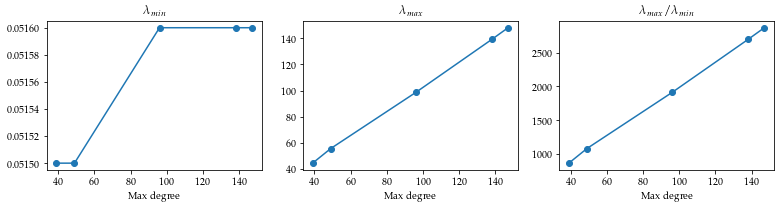

In [223]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,3))

eigmin, eigmax, eigratio = zip(*eigdata2)
labels =[r'$\lambda_{min}$', r'$\lambda_{max}$', r'$\lambda_{max}/\lambda_{min}$']
for ax, data, label in zip(fig.axes, [eigmin, eigmax, eigratio], labels):
    ax.plot(pctiles, data, '-o')
    ax.set_title(label)
    ax.set_xlabel('Max degree')
fig.tight_layout()

In [244]:
# both: uniform addition and thresholding
unif_percent = 0.37
deg_pctile = 98.9
deg_thresh = lambda g: int(np.percentile(g.degree(), deg_pctile))

graph = add_random_edges(sg, [unif_percent])[0]
graph = trim_high_degree_nodes(graph, [deg_thresh(graph)])[0]
eigd = get_laplacian_minmax(graph)
eigd

(0.3419, 56.3238, 164.73764258555133)

In [245]:
with open('./final/hepph_150.txt', 'w') as f:
    graph.write_edgelist(f)

### Chordal completion

In [170]:
def nx_MCSM(g): 
    # Maximum Cardinality Search for Computing Minimal Triangulations of Graphs
    def has_proper_path(u, v):
        valid_nodes = [u,v]+[x for x in indices if w[x] < w[u]]
        subgraph = g.subgraph(valid_nodes)
        return nx.has_path(subgraph, u, v)
    
    F, alpha = set(), {}
    indices = {nid: 0 for nid in g.nodes()}
    w = indices.copy()
    
    for i in sorted(indices, reverse=True):
        if i % 10 == 0: print i,
        v, S = max(indices.keys(), key=lambda x: w[x]), set()
        for u in indices:
            if (u!=v) and (g.has_edge(u,v) or has_proper_path(u, v)): S.add(u)
        for u in S:
            w[u] += 1
            if not g.has_edge(u,v):  F.add((u,v) if u<v else (v,u))
        alpha[v] = i
        del indices[v]
        
    h = g.copy()
    h.add_edges_from(list(F))
    return g, h, F

In [171]:
sg_nx = utils.ig_to_nx(sg)
sg_nx, sg_nx_ch, F = nx_MCSM(sg_nx)

1880 1870 1860 1850 1840 1830 1820 1810 1800 1790 1780 1770 1760 1750 1740 1730 1720 1710 1700 1690 1680 1670 1660 1650 1640 1630 1620 1610 1600 1590 1580 1570 1560 1550 1540 1530 1520 1510 1500 1490 1480 1470 1460 1450 1440 1430 1420 1410 1400 1390 1380 1370 1360 1350 1340 1330 1320 1310 1300 1290 1280 1270 1260 1250 1240 1230 1220 1210 1200 1190 1180 1170 1160 1150 1140 1130 1120 1110 1100 1090 1080 1070 1060 1050 1040 1030 1020 1010 1000 990 980 970 960 950 940 930 920 910 900 890 880 870 860 850 840 830 820 810 800 790 780 770 760 750 740 730 720 710 700 690 680 670 660 650 640 630 620 610 600 590 580 570 560 550 540 530 520 510 500 490 480 470 460 450 440 430 420 410 400 390 380 370 360 350 340 330 320 310 300 290 280 270 260 250 240 230 220 210 200 190 180 170 160 150 140 130 120 110 100 90 80 70 60 50 40 30 20 10 0


In [172]:
get_laplacian_minmax(sg)

(0.0637, 61.0767, 958.8178963893249)

In [174]:
h = sg.copy()
h.add_edges(F)

In [175]:
is_chordal(h)

True

In [176]:
get_laplacian_minmax(h)

(0.081, 472.182, 5829.407407407408)

## Run Wu

In [172]:
import gen_er
import wu

In [242]:
graph = gen_er.get_er_components_graph(50, 100, 0.5, chordal=True) 
N = len(graph.vs)
d = np.max(graph.degree())
w = graph.omega()
num_cc = len(graph.components())

In [243]:
runs_per = 50
cc_estimates = defaultdict(list)
for run_idx in xrange(runs_per):
    print "{}".format(run_idx+1),
    sgs = gen_er.get_subsampled_data(graph, every=1)
    for p, sg in sgs.iteritems():
        cj_map = wu.get_cj_values_from_order(sg)
        cc_estimates[p].append(wu.smoothed_estimator(p, cj_map.values(), N, d, w))
        # print '{:.2f}'.format(p),

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


In [245]:
def rmse(l):
    l = (np.array(l)-num_cc)**2
    l = np.sqrt(np.mean(l))
    return l/num_cc

df = pd.DataFrame()
df['p'] = cc_estimates.keys()
df['data'] = cc_estimates.values()
df['avg'] = df['data'].apply(np.mean)
df['rmse'] = df['data'].apply(rmse)
df = df.sort_values(by='p').reset_index(drop=True)
df.head()

,p,data,avg,rmse
0,0.1000,"[40.779243572716425, 42.51535321336855, 41.207...",40.430316,0.195762
1,0.1098,"[41.74378684097317, 44.08736941453143, 40.0591...",40.370256,0.197995
2,0.1204,"[40.204379268069744, 39.679809791529685, 41.84...",39.612440,0.211545
3,0.1320,"[40.893099056653185, 39.80737189140217, 40.601...",39.690028,0.209123
4,0.1446,"[39.436231359263004, 37.602394462325016, 38.09...",39.749890,0.206060


In [248]:
dfs = df.copy()
del dfs['data']
dfs.to_csv('./ER/wu_er.csv', sep=' ')

## Visualize

In [252]:
df_wu = pd.read_csv('ER/wu_er.csv', sep=' ')
df_sw = pd.read_csv('ER/ER1_rmse.txt', sep=' ', header=None)
df_sw.columns = ['p', 'a', 'rmse', 'b']

In [265]:
import matplotlib

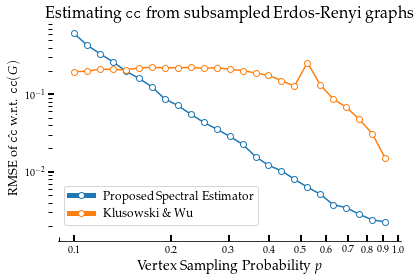

In [282]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.tick_params(direction='in', length=6, width=2, colors='k', which='major')
ax.tick_params(direction='in', length=4, width=1, colors='k', which='minor')  
sns.despine(ax=ax, offset=10)
sns.despine(ax=ax, left=True)
ax.ticklabel_format(style='plain')

ax.set_aspect(aspect='auto', adjustable='box-forced')

ax.plot(df_sw['p'], df_sw['rmse'], 'o-', mew=1, mfc='w', label='Proposed Spectral Estimator')
ax.plot(df_wu['p'], df_wu['rmse'], 'o-', mew=1, mfc='w', label='Klusowski \& Wu')
ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')

leg = ax.legend(loc='best', fontsize=12)
for legobj in leg.legendHandles: legobj.set_linewidth(5.0); legobj.set_alpha(1)
ax.set_ylabel(r'RMSE of $\hat{\texttt{cc}}$ w.r.t. $\texttt{cc}(G)$', fontsize=13)
ax.set_xlabel(r'Vertex Sampling Probability $p$', fontsize=14)
ax.set_title(r'Estimating $\texttt{cc}$ from subsampled Erdos-Renyi graphs', fontsize=16)

ax.set_xticks(np.arange(0.1, 1.01, 0.1))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
fig.savefig('plots/er.pdf')